# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

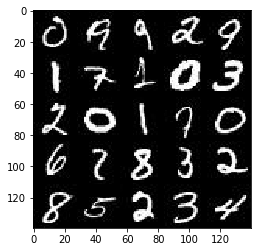

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

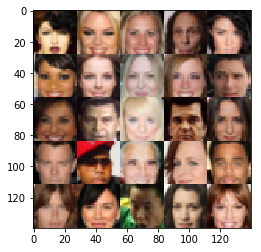

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels))
    input_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim))
    learn_rate = tf.placeholder(dtype=tf.float32)
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, is_training=True):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope("discriminator", reuse=reuse):
        
        # input: 28 * 28 * num_channels    
        x1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=5, strides=2, activation=None, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)

        # input: 14 * 14 * 64   
        x2 = tf.layers.conv2d(inputs=x1, filters=128, kernel_size=5, strides=2, activation=None, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_training,  )
        x2 = tf.maximum(alpha * x2, x2 )

        # input: 7 * 7 * 128    
        x3 = tf.layers.conv2d(inputs=x2, filters=256, kernel_size=5, strides=2, activation=None, padding='same')
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_training)
        x3 = tf.maximum(alpha * x3, x3)

        # input: 4 * 4 * 256
        x4 = tf.reshape(tensor=x3, shape=(-1, 4*4*256))
        
        # input: 4096
        logits = tf.layers.dense(inputs=x4, units=1, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)

        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, reuse=False, alpha=0.2, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    with tf.variable_scope("generator", reuse=reuse):
        
        # connect random input z to a dense layer
        x1 = tf.layers.dense(inputs=z, units=7*7*512, activation=None,  kernel_initializer=tf.contrib.layers.xavier_initializer())

        # apply batch normalization and leaky relu activation
        x2 = tf.reshape(x1, shape=(-1, 7, 7, 512))
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        # input: 7*7*512 
        x3 = tf.layers.conv2d_transpose(inputs=x2, filters=256, activation=None, kernel_size=5, strides=2, padding='same',  kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # output: 14 * 14 * 256
        
        # input: 14 * 14 * 256 
        x4 = tf.layers.conv2d_transpose(inputs=x3, filters=128, activation=None, kernel_size=5, strides=1, padding='same',  kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(inputs=x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # output: 14 * 14 * 128

        # input: 14 * 14 * 128 
        x5 = tf.layers.conv2d_transpose(inputs=x4, filters=out_channel_dim, activation=None, kernel_size=5, strides=2, padding='same',  kernel_initializer=tf.contrib.layers.xavier_initializer())
        # output: 28 * 28 * color_channels

        # rescale output using tanh
        g_model = tf.tanh(x5)
        
        return g_model


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(z = input_z, out_channel_dim=out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(images=input_real)
    d_model_fake, d_logits_fake = discriminator(images=g_model, reuse=True)
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    all_vars = [v for v in tf.trainable_variables() ]
    print("all vars found: ",len(all_vars))
    
    g_vars = [v for v in all_vars if v.name.startswith('generator')]
    print("generator vars found: ",len(g_vars), ": ", [g.name for g in g_vars])
    
    d_vars = [v for v in all_vars if v.name.startswith('discriminator')]
    print("discriminator vars found: ", len(d_vars), ": ", [d.name for d in d_vars])
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
        return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

all vars found:  2
generator vars found:  1 :  ['generator/Variable:0']
discriminator vars found:  1 :  ['discriminator/Variable:0']
Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, reuse=True, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """


    input_real_ph, input_z_ph, learn_rate_ph = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)    
    d_loss, g_loss = model_loss(input_real=input_real_ph, input_z=input_z_ph, out_channel_dim=data_shape[3])    
    d_opt, g_opt = model_opt(d_loss=d_loss, g_loss=g_loss, learning_rate=learn_rate_ph, beta1=beta1)
    
    show_fig_every_batch = 60
    show_loss_every_batch = 20
    
    num_channels = data_shape[3]
    if(num_channels==3):
        image_mode_code = "RGB"
    else:
        image_mode_code = "L"
        
    show_images = 16
    random_constant_z = tf.random_uniform(dtype=tf.float32, minval=-1, maxval=1, shape=(show_images,z_dim))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):

            batch_num = 0
            for batch_images in get_batches(batch_size):
                
                batch_num +=1
                '''
                NOTE: Important! I needed to rescale the batch_images by a factor of 2 because my
                generator function generates values from between -1 and +1 (consequence of using)
                the tanh function. The get_batches(..) method generates images between -0.5 to 0.5.
                Multiplying by 2 allows the discriminator to train on inputs ranging from -1 to 1.
                '''
        
                batch_images = batch_images * 2.
                
                sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))                
                
                sess.run(d_opt, feed_dict={input_real_ph: batch_images, input_z_ph: sample_z, learn_rate_ph: learning_rate})
                
                sess.run(g_opt, feed_dict={input_z_ph: sample_z, input_real_ph: batch_images, learn_rate_ph: learning_rate}) 

                if(batch_num%show_loss_every_batch == 0 ):
                    discr_loss = d_loss.eval({input_real_ph: batch_images, input_z_ph: sample_z})
                    gener_loss = g_loss.eval({input_z_ph: sample_z})
                    print("discriminator loss: ", discr_loss, "generator loss: ", gener_loss)
                
                if(batch_num%show_fig_every_batch == 0):
                    show_generator_output(sess=sess, n_images=show_images, input_z=input_z_ph, out_channel_dim=num_channels, image_mode=data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

all vars found:  26
generator vars found:  14 :  ['generator/x1.dense/kernel:0', 'generator/x1.dense/bias:0', 'generator/x2.bn/beta:0', 'generator/x2.bn/gamma:0', 'generator/x3.conv2d_t/kernel:0', 'generator/x3.conv2d_t/bias:0', 'generator/x3.bn/beta:0', 'generator/x3.bn/gamma:0', 'generator/x4.conv2d_t/kernel:0', 'generator/x4.conv2d_t/bias:0', 'generator/x4.bn/beta:0', 'generator/x4.bn/gamma:0', 'generator/x5.conv2d_t/kernel:0', 'generator/x5.conv2d_t/bias:0']
discriminator vars found:  12 :  ['discriminator/x1.conv2d/kernel:0', 'discriminator/x1.conv2d/bias:0', 'discriminator/x2.conv2d/kernel:0', 'discriminator/x2.conv2d/bias:0', 'discriminator/x2.bn/beta:0', 'discriminator/x2.bn/gamma:0', 'discriminator/x3.conv2d/kernel:0', 'discriminator/x3.conv2d/bias:0', 'discriminator/x3.bn/beta:0', 'discriminator/x3.bn/gamma:0', 'discriminator/x4.dense/kernel:0', 'discriminator/x4.dense/bias:0']
discriminator loss:  2.81134 generator loss:  0.0852962
discriminator loss:  1.39254 generator loss

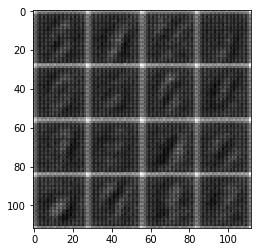

discriminator loss:  1.21621 generator loss:  1.53908
discriminator loss:  1.25209 generator loss:  1.34393
discriminator loss:  1.0823 generator loss:  1.27858


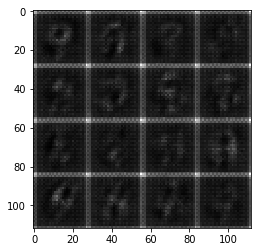

discriminator loss:  1.22327 generator loss:  0.523572
discriminator loss:  1.17591 generator loss:  1.73471


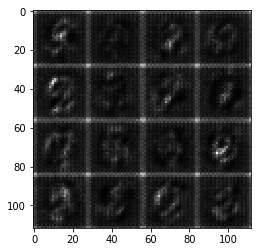

discriminator loss:  0.995543 generator loss:  0.684012
discriminator loss:  1.19156 generator loss:  2.11943
discriminator loss:  1.1228 generator loss:  2.30701


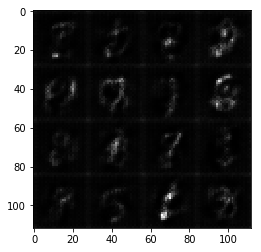

discriminator loss:  0.925181 generator loss:  1.70656
discriminator loss:  1.1012 generator loss:  2.4178


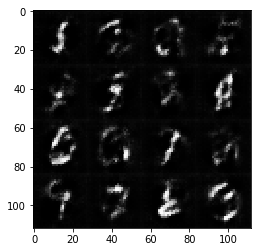

discriminator loss:  1.06911 generator loss:  1.91939
discriminator loss:  0.989848 generator loss:  0.791349
discriminator loss:  0.914704 generator loss:  0.862513


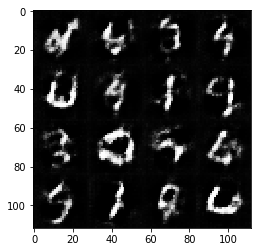

discriminator loss:  0.968629 generator loss:  1.76222
discriminator loss:  1.43926 generator loss:  0.347599


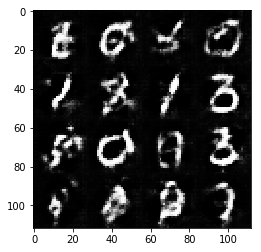

discriminator loss:  0.836978 generator loss:  1.20866
discriminator loss:  1.02823 generator loss:  0.790868
discriminator loss:  1.16474 generator loss:  0.493457


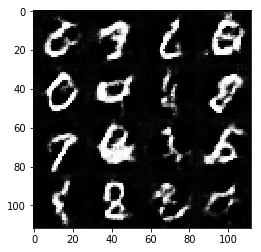

discriminator loss:  0.954131 generator loss:  1.21862
discriminator loss:  0.930158 generator loss:  1.52997


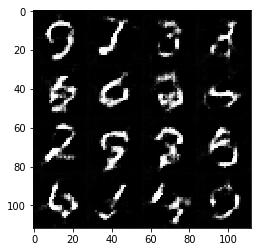

discriminator loss:  0.886324 generator loss:  1.22954


In [13]:
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

all vars found:  26
generator vars found:  14 :  ['generator/dense/kernel:0', 'generator/dense/bias:0', 'generator/batch_normalization/beta:0', 'generator/batch_normalization/gamma:0', 'generator/conv2d_transpose/kernel:0', 'generator/conv2d_transpose/bias:0', 'generator/batch_normalization_1/beta:0', 'generator/batch_normalization_1/gamma:0', 'generator/conv2d_transpose_1/kernel:0', 'generator/conv2d_transpose_1/bias:0', 'generator/batch_normalization_2/beta:0', 'generator/batch_normalization_2/gamma:0', 'generator/conv2d_transpose_2/kernel:0', 'generator/conv2d_transpose_2/bias:0']
discriminator vars found:  12 :  ['discriminator/conv2d/kernel:0', 'discriminator/conv2d/bias:0', 'discriminator/conv2d_1/kernel:0', 'discriminator/conv2d_1/bias:0', 'discriminator/batch_normalization/beta:0', 'discriminator/batch_normalization/gamma:0', 'discriminator/conv2d_2/kernel:0', 'discriminator/conv2d_2/bias:0', 'discriminator/batch_normalization_1/beta:0', 'discriminator/batch_normalization_1/gam

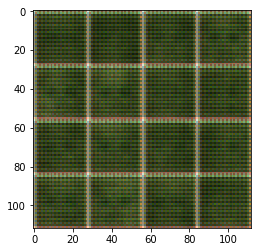

discriminator loss:  1.14781 generator loss:  1.3886
discriminator loss:  1.77308 generator loss:  0.674349
discriminator loss:  1.54233 generator loss:  0.933349


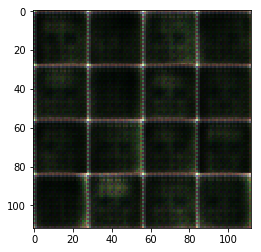

discriminator loss:  1.08493 generator loss:  0.902389
discriminator loss:  1.79643 generator loss:  0.314645
discriminator loss:  1.44737 generator loss:  0.53541


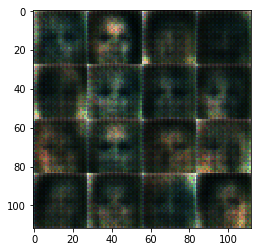

discriminator loss:  0.970557 generator loss:  1.14412
discriminator loss:  1.09508 generator loss:  1.83657
discriminator loss:  1.14964 generator loss:  1.27019


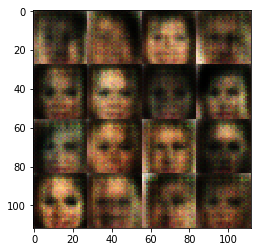

discriminator loss:  1.14936 generator loss:  0.825015
discriminator loss:  1.34044 generator loss:  0.49769
discriminator loss:  1.86461 generator loss:  0.408505


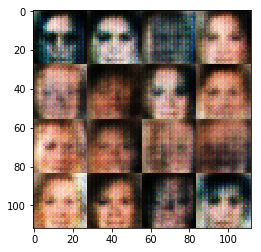

discriminator loss:  1.54724 generator loss:  0.555844
discriminator loss:  1.28449 generator loss:  1.01268
discriminator loss:  1.43396 generator loss:  0.642261


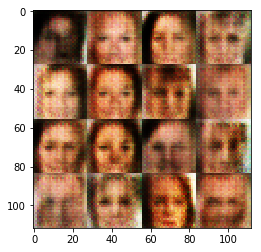

discriminator loss:  1.51356 generator loss:  0.684212
discriminator loss:  1.59563 generator loss:  0.548907
discriminator loss:  1.20299 generator loss:  0.833732


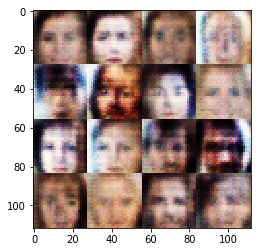

discriminator loss:  1.29237 generator loss:  0.784215
discriminator loss:  1.4141 generator loss:  0.500745
discriminator loss:  1.43376 generator loss:  0.601193


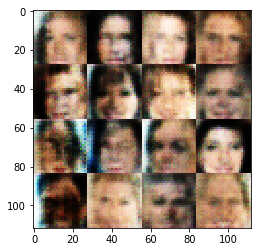

discriminator loss:  1.32202 generator loss:  0.756382
discriminator loss:  1.62838 generator loss:  0.465186
discriminator loss:  1.36809 generator loss:  0.609388


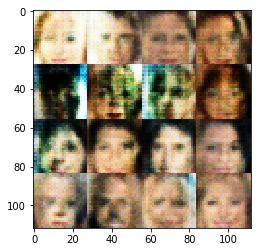

discriminator loss:  1.37333 generator loss:  0.668265
discriminator loss:  1.28313 generator loss:  0.688162
discriminator loss:  1.21685 generator loss:  0.949022


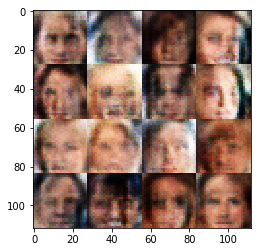

discriminator loss:  1.33503 generator loss:  0.725333
discriminator loss:  1.22717 generator loss:  1.00477
discriminator loss:  1.36372 generator loss:  0.653149


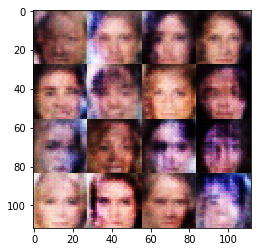

discriminator loss:  1.1683 generator loss:  0.726657
discriminator loss:  1.12548 generator loss:  0.949903
discriminator loss:  1.36082 generator loss:  0.510996


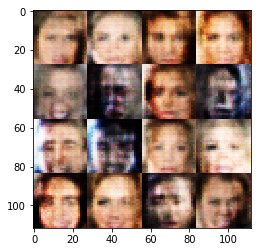

discriminator loss:  1.33372 generator loss:  0.621544
discriminator loss:  1.20789 generator loss:  0.994466
discriminator loss:  1.23283 generator loss:  1.07352


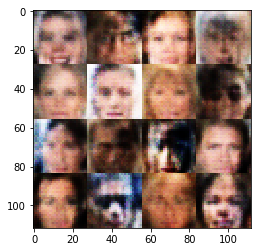

discriminator loss:  1.21199 generator loss:  0.691371
discriminator loss:  1.03575 generator loss:  2.34761
discriminator loss:  1.12363 generator loss:  0.784237


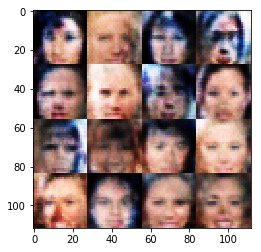

discriminator loss:  1.50284 generator loss:  0.39576
discriminator loss:  1.46846 generator loss:  1.96549
discriminator loss:  1.09152 generator loss:  0.891533


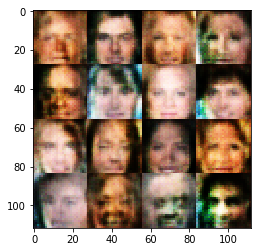

discriminator loss:  1.30347 generator loss:  0.808079
discriminator loss:  1.53729 generator loss:  0.353074
discriminator loss:  1.25462 generator loss:  0.635627


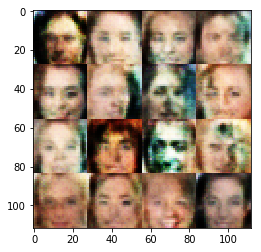

discriminator loss:  1.21458 generator loss:  0.662379
discriminator loss:  0.813374 generator loss:  1.24404
discriminator loss:  1.36102 generator loss:  0.480474


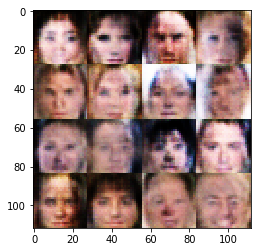

discriminator loss:  0.842896 generator loss:  1.42421
discriminator loss:  1.48326 generator loss:  0.408686
discriminator loss:  1.13845 generator loss:  1.24613


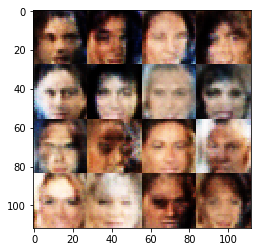

discriminator loss:  1.11171 generator loss:  0.766293
discriminator loss:  1.33041 generator loss:  0.627954
discriminator loss:  1.04984 generator loss:  0.711154


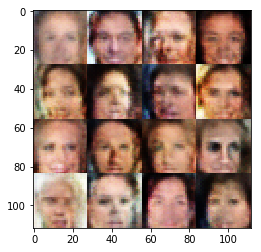

discriminator loss:  1.18069 generator loss:  0.887977
discriminator loss:  1.18411 generator loss:  0.687487
discriminator loss:  1.46147 generator loss:  0.472185


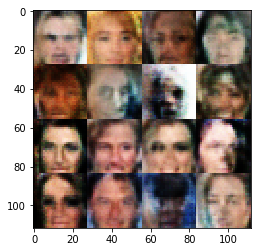

discriminator loss:  1.13384 generator loss:  0.819233
discriminator loss:  1.50686 generator loss:  0.50746
discriminator loss:  1.29929 generator loss:  0.657034


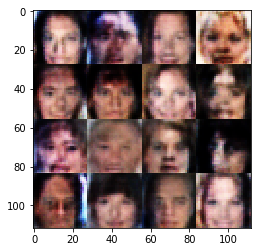

discriminator loss:  0.959441 generator loss:  0.913452
discriminator loss:  1.29985 generator loss:  0.680137
discriminator loss:  0.906608 generator loss:  0.993513


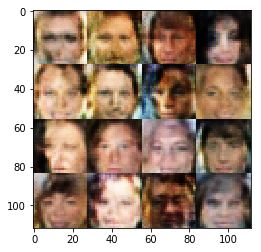

discriminator loss:  1.1823 generator loss:  0.589249
discriminator loss:  1.25449 generator loss:  0.484404
discriminator loss:  1.01697 generator loss:  0.915841


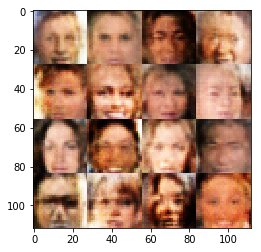

discriminator loss:  1.07175 generator loss:  0.87555
discriminator loss:  0.964117 generator loss:  1.17898
discriminator loss:  0.935744 generator loss:  0.91642


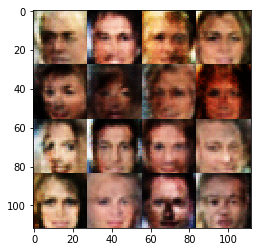

discriminator loss:  0.891293 generator loss:  1.04233
discriminator loss:  0.994575 generator loss:  0.988425
discriminator loss:  1.27889 generator loss:  0.541488


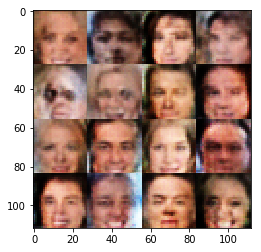

discriminator loss:  0.975395 generator loss:  0.982384
discriminator loss:  1.04799 generator loss:  0.659536
discriminator loss:  1.50356 generator loss:  0.37805


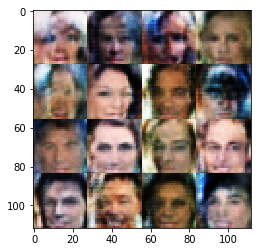

discriminator loss:  1.9143 generator loss:  0.2105
discriminator loss:  1.61284 generator loss:  0.320949
discriminator loss:  0.872151 generator loss:  1.48696


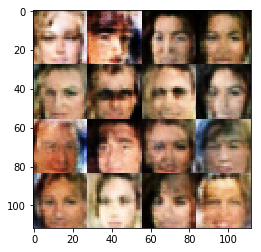

discriminator loss:  1.00941 generator loss:  2.67509
discriminator loss:  0.703324 generator loss:  1.7223
discriminator loss:  0.888211 generator loss:  0.781244


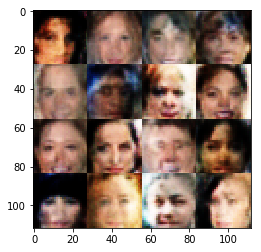

discriminator loss:  1.2148 generator loss:  0.580531
discriminator loss:  0.772651 generator loss:  0.961925
discriminator loss:  0.801698 generator loss:  2.51606


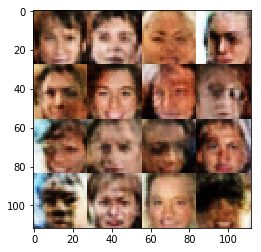

discriminator loss:  0.773861 generator loss:  1.37075
discriminator loss:  1.24215 generator loss:  0.450989
discriminator loss:  0.516209 generator loss:  1.55182


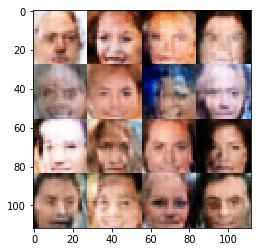

discriminator loss:  0.429416 generator loss:  1.94251
discriminator loss:  0.825498 generator loss:  0.78137
discriminator loss:  1.20761 generator loss:  0.473912


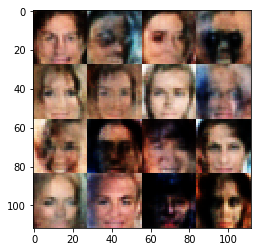

discriminator loss:  0.333593 generator loss:  3.72401
discriminator loss:  0.69456 generator loss:  3.43574
discriminator loss:  0.617128 generator loss:  1.21311


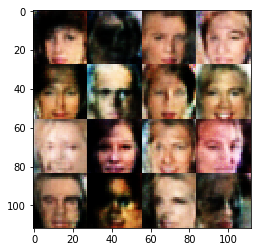

discriminator loss:  0.564567 generator loss:  1.05739
discriminator loss:  0.828477 generator loss:  0.820625
discriminator loss:  0.789448 generator loss:  3.23491


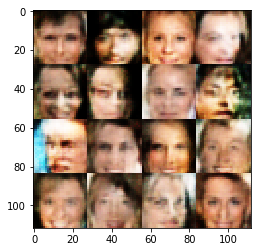

discriminator loss:  0.686663 generator loss:  0.983114
discriminator loss:  0.253958 generator loss:  2.25752
discriminator loss:  0.500258 generator loss:  4.24422


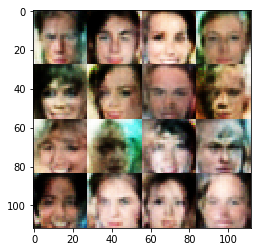

discriminator loss:  1.70504 generator loss:  2.51336
discriminator loss:  0.764965 generator loss:  4.39241
discriminator loss:  0.697822 generator loss:  0.965921


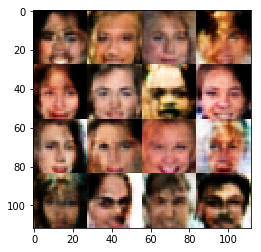

discriminator loss:  0.38674 generator loss:  1.53
discriminator loss:  0.578961 generator loss:  2.53723
discriminator loss:  0.383524 generator loss:  2.23905


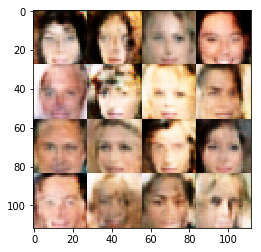

discriminator loss:  0.271233 generator loss:  3.60219
discriminator loss:  0.340042 generator loss:  2.41961
discriminator loss:  0.348371 generator loss:  3.07316


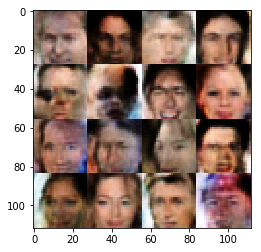

discriminator loss:  0.546296 generator loss:  1.1755
discriminator loss:  0.911487 generator loss:  0.65499
discriminator loss:  0.319841 generator loss:  2.38344


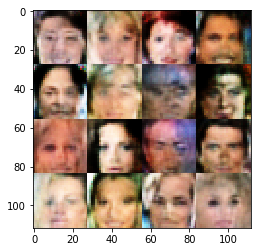

discriminator loss:  0.79447 generator loss:  0.72649
discriminator loss:  0.460615 generator loss:  1.41177
discriminator loss:  0.461873 generator loss:  1.45752


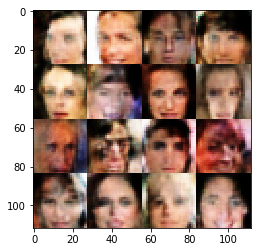

discriminator loss:  0.26495 generator loss:  2.22109
discriminator loss:  1.46664 generator loss:  3.1733
discriminator loss:  0.209154 generator loss:  3.96403


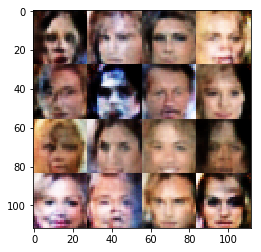

discriminator loss:  0.088134 generator loss:  5.54066
discriminator loss:  0.650092 generator loss:  3.80968
discriminator loss:  0.421558 generator loss:  4.66363


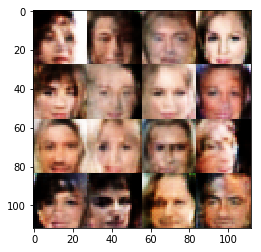

discriminator loss:  0.121096 generator loss:  3.56255
discriminator loss:  0.200311 generator loss:  2.45425
discriminator loss:  0.302079 generator loss:  1.81924


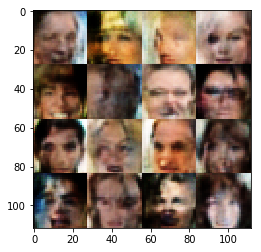

discriminator loss:  0.256418 generator loss:  1.91851
discriminator loss:  2.32877 generator loss:  5.62254
discriminator loss:  0.261643 generator loss:  2.52081


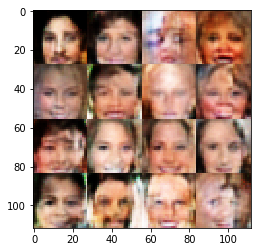

discriminator loss:  0.294043 generator loss:  2.02185
discriminator loss:  0.937702 generator loss:  3.84319
discriminator loss:  0.921674 generator loss:  0.770705


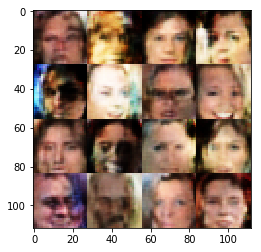

discriminator loss:  0.833338 generator loss:  4.00199
discriminator loss:  0.203287 generator loss:  4.58269
discriminator loss:  1.55802 generator loss:  2.63557


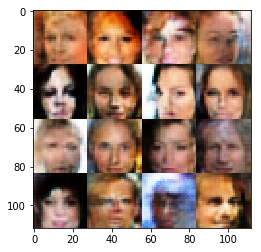

discriminator loss:  0.291245 generator loss:  2.4803
discriminator loss:  0.176997 generator loss:  2.8537
discriminator loss:  1.02925 generator loss:  0.637662


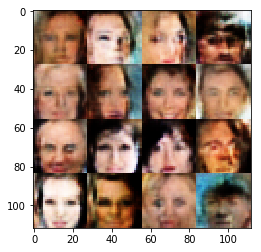

discriminator loss:  0.562773 generator loss:  1.17999
discriminator loss:  0.259043 generator loss:  4.46384
discriminator loss:  0.348571 generator loss:  1.78408


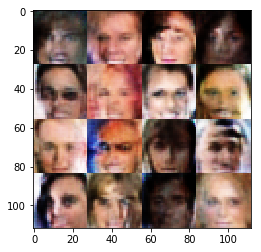

discriminator loss:  0.402847 generator loss:  1.85917
discriminator loss:  0.334753 generator loss:  2.35507
discriminator loss:  0.511102 generator loss:  1.17421


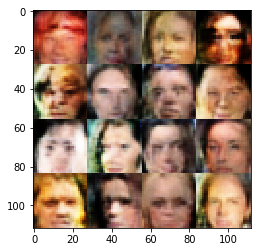

discriminator loss:  0.183039 generator loss:  2.472
discriminator loss:  1.73529 generator loss:  2.50767
discriminator loss:  0.211456 generator loss:  3.08992


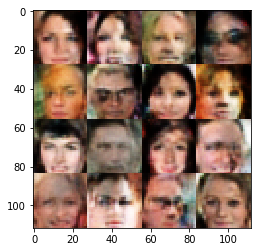

discriminator loss:  0.393057 generator loss:  3.10081
discriminator loss:  0.154341 generator loss:  2.84643
discriminator loss:  1.9429 generator loss:  3.71985


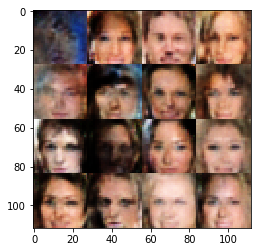

discriminator loss:  0.700723 generator loss:  0.91223
discriminator loss:  0.193999 generator loss:  2.33429
discriminator loss:  0.742095 generator loss:  0.879139


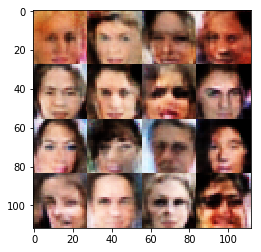

discriminator loss:  0.416216 generator loss:  4.73862
discriminator loss:  0.230684 generator loss:  2.31486
discriminator loss:  0.162205 generator loss:  2.99581


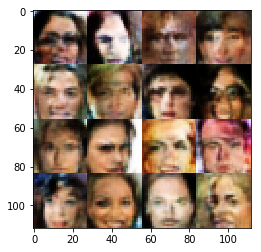

discriminator loss:  2.45166 generator loss:  0.172397
discriminator loss:  0.294107 generator loss:  4.67758
discriminator loss:  0.254725 generator loss:  2.90909
discriminator loss:  0.240701 generator loss:  5.08324
discriminator loss:  0.050643 generator loss:  5.20214


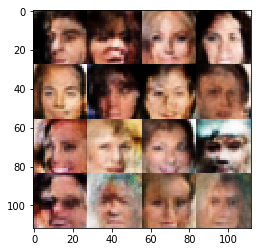

discriminator loss:  0.124708 generator loss:  4.44804
discriminator loss:  3.92945 generator loss:  0.0403038
discriminator loss:  0.475386 generator loss:  1.26667


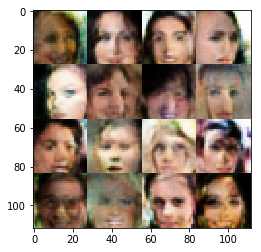

discriminator loss:  0.133047 generator loss:  5.52155
discriminator loss:  1.31663 generator loss:  0.440348
discriminator loss:  0.140829 generator loss:  3.73044


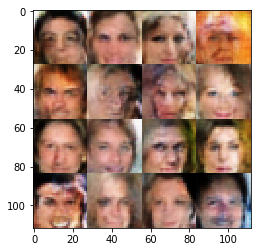

discriminator loss:  0.121632 generator loss:  5.21222
discriminator loss:  0.811718 generator loss:  1.53781
discriminator loss:  0.0730365 generator loss:  5.25843


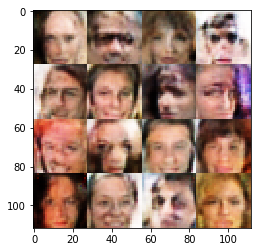

discriminator loss:  0.677979 generator loss:  1.14143
discriminator loss:  0.203206 generator loss:  3.14477
discriminator loss:  0.211553 generator loss:  2.50125


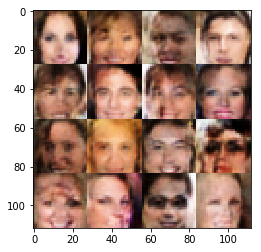

discriminator loss:  0.286388 generator loss:  1.91063
discriminator loss:  0.127665 generator loss:  3.55266
discriminator loss:  0.143619 generator loss:  3.86455


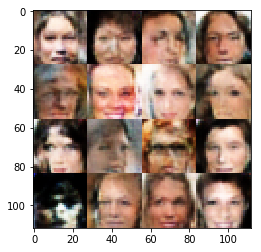

discriminator loss:  0.238383 generator loss:  3.43778
discriminator loss:  0.308789 generator loss:  1.66055
discriminator loss:  0.21616 generator loss:  2.344


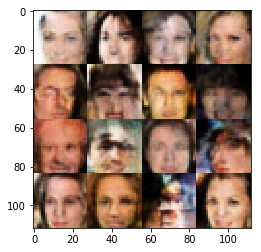

discriminator loss:  0.644497 generator loss:  1.03523
discriminator loss:  0.228521 generator loss:  2.78423
discriminator loss:  0.212797 generator loss:  3.87349


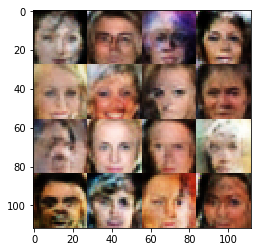

discriminator loss:  0.114254 generator loss:  3.35527
discriminator loss:  0.652732 generator loss:  1.99313
discriminator loss:  0.133587 generator loss:  4.16159


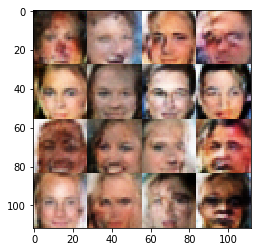

discriminator loss:  0.932193 generator loss:  0.737922
discriminator loss:  1.0354 generator loss:  3.79236
discriminator loss:  0.0763013 generator loss:  5.18633


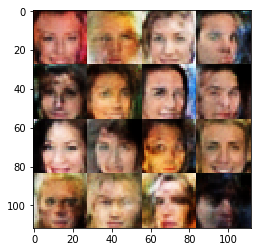

discriminator loss:  0.234177 generator loss:  3.35711
discriminator loss:  0.156569 generator loss:  5.38778
discriminator loss:  0.142869 generator loss:  3.36993


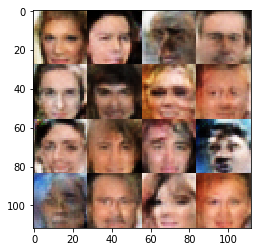

discriminator loss:  1.1845 generator loss:  0.473582
discriminator loss:  0.348809 generator loss:  1.81848
discriminator loss:  0.620102 generator loss:  2.23996


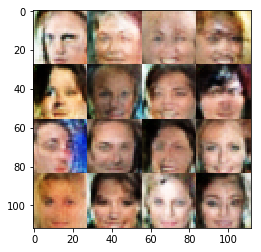

discriminator loss:  0.218246 generator loss:  6.0515
discriminator loss:  0.421664 generator loss:  1.48286
discriminator loss:  0.299747 generator loss:  5.15503


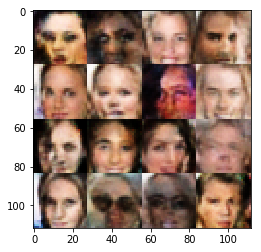

discriminator loss:  0.144679 generator loss:  2.87137
discriminator loss:  0.587211 generator loss:  1.00897
discriminator loss:  0.668125 generator loss:  1.01875


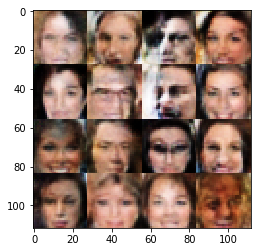

discriminator loss:  1.8631 generator loss:  5.28393
discriminator loss:  0.241172 generator loss:  3.57575
discriminator loss:  0.295155 generator loss:  2.00514


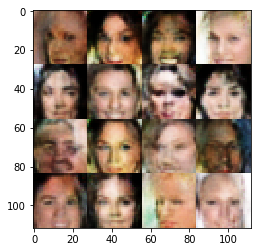

discriminator loss:  0.342583 generator loss:  2.07727
discriminator loss:  0.130408 generator loss:  3.00786
discriminator loss:  0.275829 generator loss:  2.29215


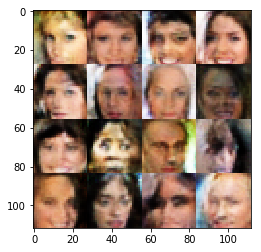

discriminator loss:  0.15132 generator loss:  3.09369
discriminator loss:  0.50788 generator loss:  1.2654
discriminator loss:  0.302571 generator loss:  2.62748


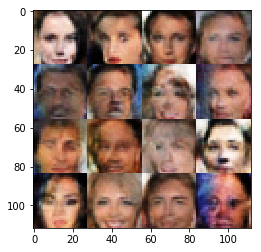

discriminator loss:  0.117728 generator loss:  3.67887
discriminator loss:  0.867439 generator loss:  3.60548
discriminator loss:  0.942171 generator loss:  0.764832


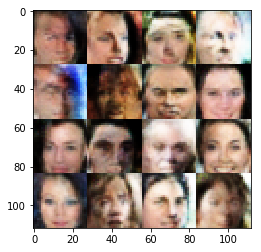

discriminator loss:  0.291441 generator loss:  3.68173
discriminator loss:  0.41205 generator loss:  1.39322
discriminator loss:  0.783967 generator loss:  0.77755


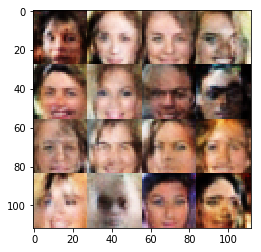

discriminator loss:  0.644817 generator loss:  0.976772
discriminator loss:  0.0685678 generator loss:  4.14096
discriminator loss:  0.135582 generator loss:  3.17405


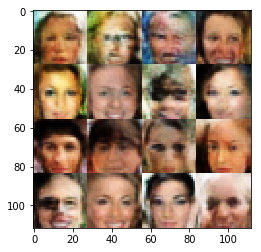

discriminator loss:  1.34501 generator loss:  0.43894
discriminator loss:  0.118301 generator loss:  3.76749
discriminator loss:  0.592795 generator loss:  1.11313


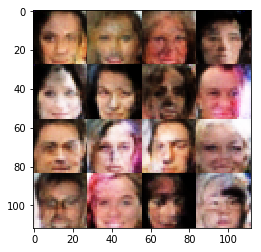

discriminator loss:  0.239011 generator loss:  3.8935
discriminator loss:  0.304437 generator loss:  3.17867
discriminator loss:  0.367713 generator loss:  2.049


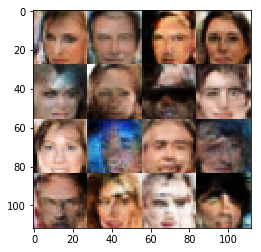

discriminator loss:  0.443939 generator loss:  1.83729
discriminator loss:  1.08847 generator loss:  0.590299
discriminator loss:  0.111371 generator loss:  4.61166


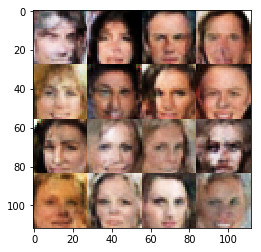

discriminator loss:  0.0763643 generator loss:  5.13959
discriminator loss:  0.283802 generator loss:  3.78638
discriminator loss:  0.44934 generator loss:  2.55795


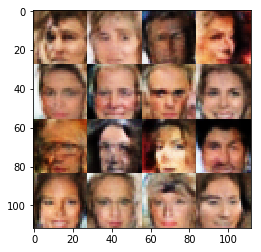

discriminator loss:  0.263547 generator loss:  2.13044
discriminator loss:  0.105893 generator loss:  3.69231
discriminator loss:  0.175922 generator loss:  2.80746


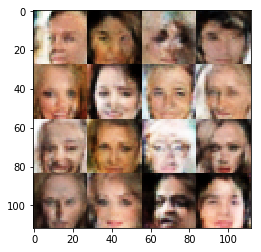

discriminator loss:  0.0793813 generator loss:  3.3942
discriminator loss:  0.788162 generator loss:  0.777441
discriminator loss:  0.183593 generator loss:  2.32101


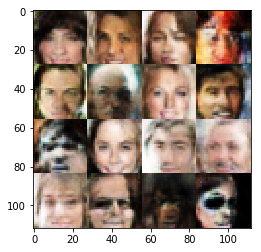

discriminator loss:  1.10777 generator loss:  0.534798
discriminator loss:  0.224348 generator loss:  2.65443
discriminator loss:  0.230269 generator loss:  2.1494


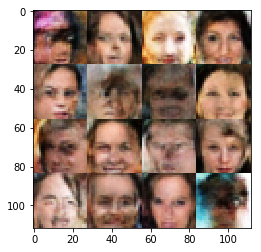

discriminator loss:  0.229503 generator loss:  2.14245
discriminator loss:  0.575547 generator loss:  4.14419
discriminator loss:  3.38617 generator loss:  0.0501263


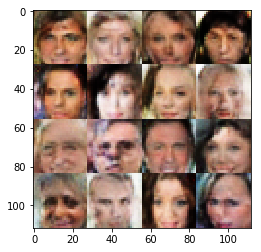

discriminator loss:  0.438069 generator loss:  2.4032
discriminator loss:  1.91299 generator loss:  0.246971
discriminator loss:  0.485065 generator loss:  1.29419


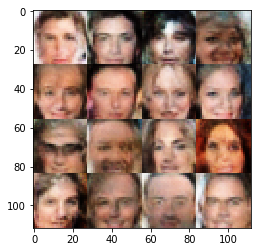

discriminator loss:  0.108257 generator loss:  4.92109
discriminator loss:  0.101081 generator loss:  4.32076
discriminator loss:  0.632363 generator loss:  1.07637


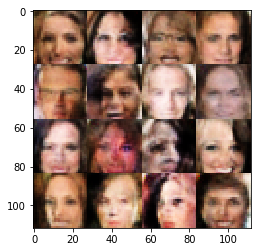

discriminator loss:  0.169854 generator loss:  2.83891
discriminator loss:  0.19316 generator loss:  3.09295
discriminator loss:  0.168281 generator loss:  3.46211


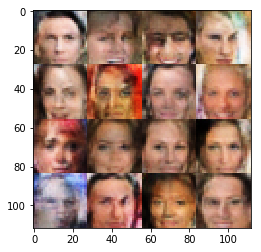

discriminator loss:  0.40206 generator loss:  1.38802
discriminator loss:  0.0719653 generator loss:  3.83683
discriminator loss:  0.364936 generator loss:  1.63467


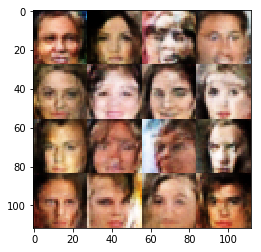

discriminator loss:  0.675775 generator loss:  3.49553
discriminator loss:  0.354602 generator loss:  1.73123
discriminator loss:  2.68934 generator loss:  0.137966


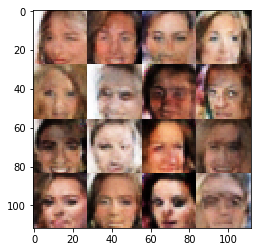

discriminator loss:  1.18503 generator loss:  0.521029
discriminator loss:  1.05988 generator loss:  0.540376
discriminator loss:  0.117218 generator loss:  4.97035


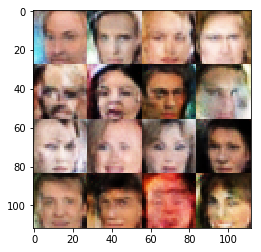

discriminator loss:  0.180534 generator loss:  3.1587
discriminator loss:  0.0701657 generator loss:  4.56157
discriminator loss:  0.12035 generator loss:  3.41034


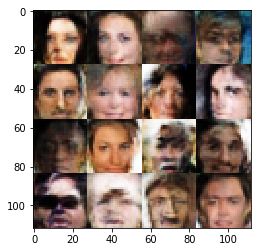

discriminator loss:  0.10488 generator loss:  4.84528
discriminator loss:  0.161176 generator loss:  2.93405
discriminator loss:  0.159134 generator loss:  2.43034


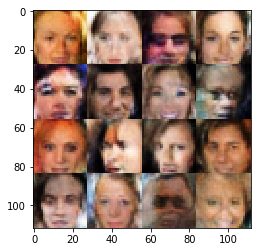

discriminator loss:  1.13913 generator loss:  0.490158
discriminator loss:  0.448059 generator loss:  2.13854
discriminator loss:  0.162743 generator loss:  2.66306


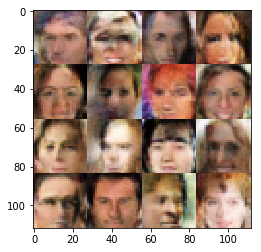

discriminator loss:  1.25621 generator loss:  0.532099
discriminator loss:  0.439733 generator loss:  1.48416
discriminator loss:  0.316561 generator loss:  2.60774


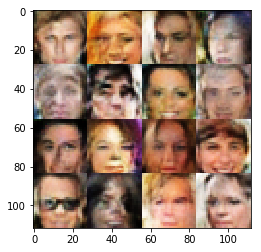

discriminator loss:  0.395938 generator loss:  1.45385
discriminator loss:  0.143852 generator loss:  2.94319
discriminator loss:  0.104181 generator loss:  3.35517


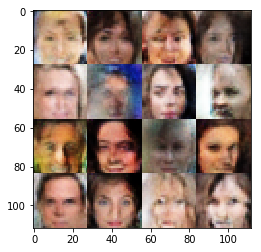

discriminator loss:  0.776493 generator loss:  0.906613
discriminator loss:  0.976541 generator loss:  0.75191
discriminator loss:  0.178785 generator loss:  2.66985


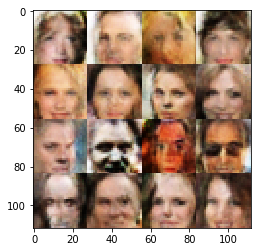

discriminator loss:  0.199208 generator loss:  3.35463
discriminator loss:  0.109789 generator loss:  2.94967
discriminator loss:  1.07998 generator loss:  0.603027


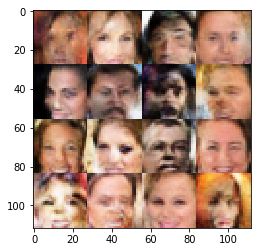

discriminator loss:  0.231997 generator loss:  2.27675
discriminator loss:  0.465718 generator loss:  1.32178
discriminator loss:  0.243728 generator loss:  2.18


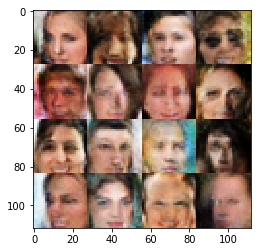

discriminator loss:  0.722423 generator loss:  0.89284
discriminator loss:  0.882172 generator loss:  0.817343
discriminator loss:  0.228679 generator loss:  3.25644


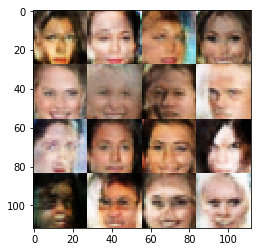

discriminator loss:  0.188562 generator loss:  2.14043
discriminator loss:  0.0886926 generator loss:  4.26509
discriminator loss:  0.12361 generator loss:  3.05784


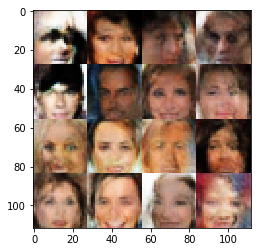

discriminator loss:  3.11623 generator loss:  0.0883193
discriminator loss:  0.57949 generator loss:  1.19299
discriminator loss:  0.220305 generator loss:  6.40806


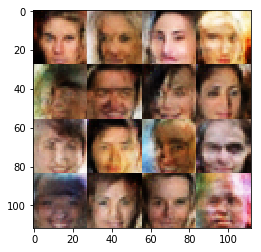

discriminator loss:  0.427368 generator loss:  1.31426
discriminator loss:  0.590152 generator loss:  1.57701
discriminator loss:  0.0983619 generator loss:  3.99317


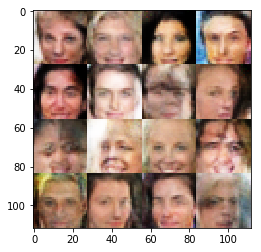

discriminator loss:  0.190654 generator loss:  2.49245
discriminator loss:  2.14868 generator loss:  0.249361
discriminator loss:  0.316876 generator loss:  1.72292


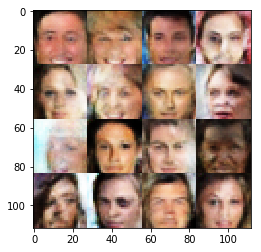

discriminator loss:  0.515884 generator loss:  1.23315
discriminator loss:  0.374095 generator loss:  1.60282
discriminator loss:  0.128978 generator loss:  3.14521


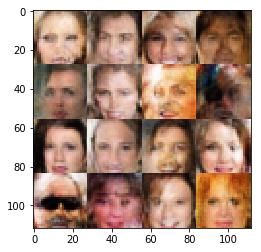

discriminator loss:  0.438241 generator loss:  1.32319
discriminator loss:  0.0899341 generator loss:  4.42303
discriminator loss:  0.301068 generator loss:  1.75014


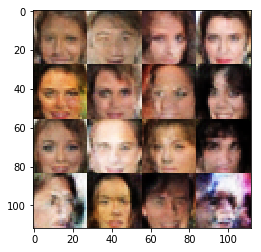

discriminator loss:  0.383335 generator loss:  1.43112
discriminator loss:  0.0982703 generator loss:  3.02619
discriminator loss:  1.13758 generator loss:  2.37758


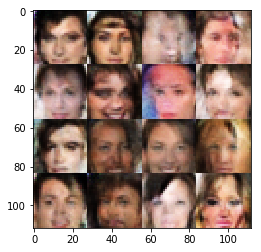

discriminator loss:  0.8137 generator loss:  0.923497
discriminator loss:  0.283369 generator loss:  1.84621
discriminator loss:  0.0674191 generator loss:  5.08196


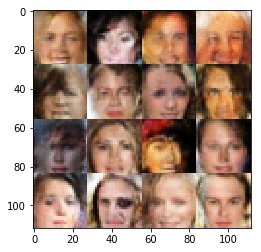

discriminator loss:  0.108317 generator loss:  3.643
discriminator loss:  0.294836 generator loss:  1.86137
discriminator loss:  0.763043 generator loss:  3.57061


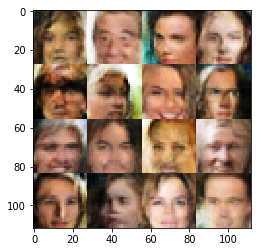

discriminator loss:  2.18595 generator loss:  0.181549
discriminator loss:  0.0715995 generator loss:  4.07629


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.